---
category: til
date: '2015-10-29'
kernelspec:
  display_name: Python 2
  language: python
  name: python3
language_info:
  codemirror_mode:
    name: ipython
    version: 2
  file_extension: .py
  mimetype: text/x-python
  name: python
  nbconvert_exporter: python
  pygments_lexer: ipython3
  version: 2.7.10
redirect: nih-grant-analysis
tags:
- python
- statistics
- visualization
- grants
title: NIH grant analysis
---

# NIH Fellowship Success Rates
As I'm entering the final years of graduate school, I've been applying for a few typical "pre-doc" fellowships. One of these is the NRSA, which is notorious for requiring you to wade through forests of beaurocratic documents (seriously, their "guidelines" for writing an NRSA are over 100 pages!). Doing so ends up taking a LOT of time.

This got me wondering what kind of success rates these grants have in the first place. For those who haven't gone through the process before, it's a bit opaque:

## How the NRSA works
Basically, each NRSA grant is reviewed by a panel of people. They individually review your proposal (which is upwards of 20 pages), and assign it a score in one of several categories. The group then meets, and they give your proposal an "impact score". This score is then compared with the distribution of scores for all the other proposals in your category, and then a cutoff is made based on the percentiles that they will fund.

Each year, they change the cutoff, and thus the number of NRSAs, that will be funded. Importantly, this also differs significantly by the NIH branch that oversees your application. Some have much higher success rates than others. For those who are curious, I'm putting a list of the NIH acronyms and their respective centers at the end.

## Some data!
I did a bit of digging and found a dataset for NRSA success rates over the last few years. It's broken down by grant type, as well as by NIH branch. The results are interesting so I thought I'd put them out there.

**Note** - this dataset and a few others can be found on the NIH website [here](https://report.nih.gov/funding/nih-budget-and-spending-data-past-fiscal-years/success-rates). I encourage you to check it out! Thank god for open data (even if it's really hard to find).

In [ ]:
# First we'll import a few helpful tools for cleaning and plotting
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re
import numpy as np
%matplotlib inline

In [ ]:
# Load the data - note that each row is a grant type/year/agency
data = pd.read_excel('./data/nih_nrsa_success_rates.xls', header=2)
data = data.convert_objects(convert_numeric=True)
data.head()

,Fiscal Year,Activity Code,NIH Institute/Center,Number of Applications Reviewed,Number of Applications Awarded,Success Rate2,Total Funding3
0,2005,F05,NCCAM,7,2,0.285714,123572
1,2005,F05,NINDS,4,3,0.750000,163368
2,2005,F05,Total,11,5,0.454545,286940
3,2005,F30,NIDA,11,6,0.545455,189408
4,2005,F30,NIDCD,7,2,0.285714,53713


First, we'll do some cleaning to remove annoying things like special characters and spaces. We'll focus on the "success rate2" variable, which describes the % of proposals that were funded that year.

In [ ]:
# Make the columns easier to play with
col_mapping = {col: col.strip(' ').replace(' ', '_').replace('/', '_').\
               strip().\
               lower() for col in data.columns}
data = data.rename(columns=col_mapping)

# Remove missing values for success rate
data = data.dropna(subset=['success_rate2',
                           'fiscal_year',
                           'nih_institute_center'])

# Remove all non-word characters from names
data['nih_institute_center'] = data['nih_institute_center'].\
    apply(lambda a: re.sub('[^a-zA-Z]', '', a))

# Remove center values that aren't as useful
remove_centers = ["Total", "ODOther"]
data = data.query('nih_institute_center not in @remove_centers')

First, let's take a look at some general trends over time

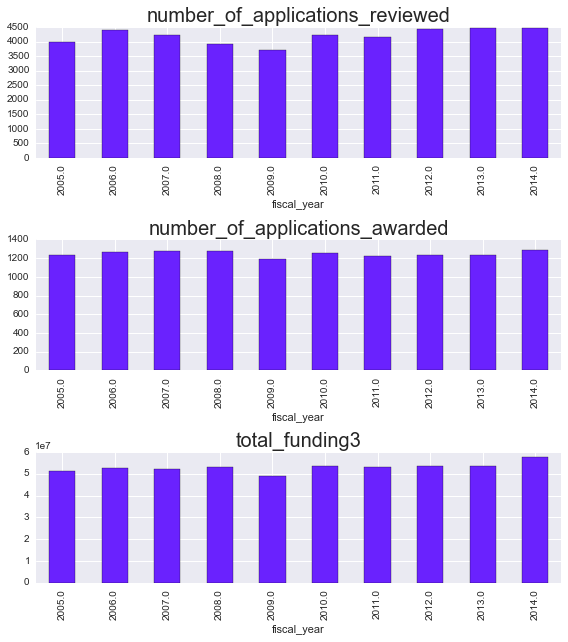

In [ ]:
f, axs = plt.subplots(3, 1, figsize=(8, 9))
combined = data.groupby('fiscal_year').sum()
coltypes = ['number_of_applications_reviewed',
            'number_of_applications_awarded',
            'total_funding3']
for ax, coltype in zip(axs, coltypes):
    combined[coltype].plot.bar(ax=ax)
    ax.set_title(coltype, fontsize=20)
plt.tight_layout()

Eyeballing it, it looks like applications have been slightly increasing per year, while applications awarded have remained relatively flat. Let's dig into that a little bit more. Rather than looking at the raw numbers, we'll focus on the success rate, or the % of applications that were funded.

We'll plot the success rates per year, per activity code. I'll plot a scatter + line for each NIH institute (in color) as well as the mean + a 3rd order polynomial fit for all of them lumped together (in black)

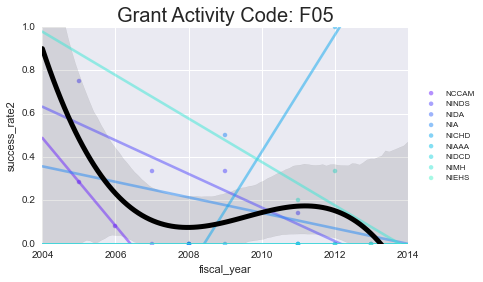

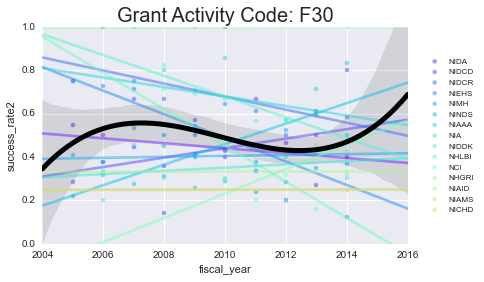

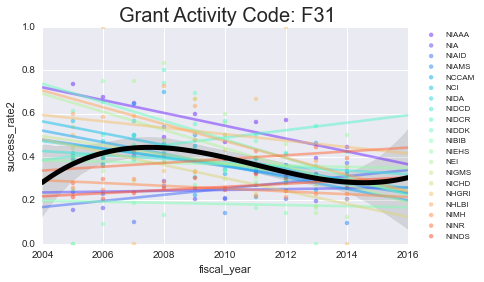

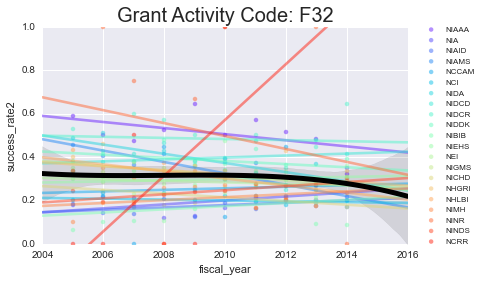

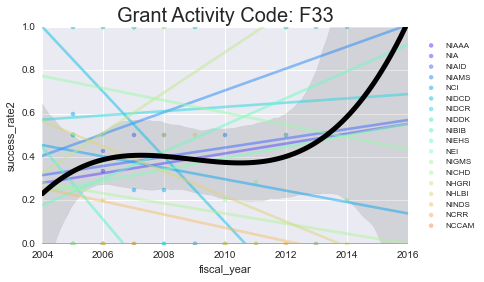

In [ ]:
for grant, gvals in data.groupby('activity_code'):
    if gvals.shape[0] > 10:
        mn_grp = gvals.groupby('fiscal_year').mean()
        lm = sns.lmplot('fiscal_year', 'success_rate2', data=gvals,
                        hue='nih_institute_center', ci=None,
                        line_kws={'alpha': .5}, scatter_kws={'alpha': .5},
                        legend=False)
        ax = lm.ax
        ax.figure.set_size_inches(6, 4)

        # If we have enough data, fit a fancier function to all points
        if gvals.shape[0] > 10:
            mn_reg = sns.regplot(
                'fiscal_year', 'success_rate2', data=gvals,
                scatter=False, line_kws={'linewidth': 5, 'c': 'k'},
                order=3)
        ax.set_title('Grant Activity Code: {0}'.format(grant), fontsize=20)
        ax.set(ylim=[0, 1])
        _ = plt.setp(mn_reg.collections[-1], color='k', alpha=.1)
        ax.legend(loc='right', bbox_to_anchor=(1.2, .5),
          ncol=1, fancybox=True, shadow=True, frameon=False, fontsize=8)
        plt.tight_layout()

As you can see - some of these data aren't well-modeled by a line in the first place. That's because there's a lot of missing data in here. However, especially for the more common grants (F31, F32) you can see some interesting (and mostly downward) trends.

# Digging in to specific grants
Next, we'll take a look at some more specific information about a select grant type. I'll focus on the F31 and F32 because that's most related to what I'm applying for.

In [ ]:
# Pull the subset of data we want
grant_type = ['F31', 'F32']
subset = data.query('activity_code in @grant_type')

# Average out the grant type column
subset = subset.groupby(['fiscal_year', 'nih_institute_center']).mean().reset_index()

We'll plot the successrate (y-axis) as a function of year (color) for each NIH center (x-axis).

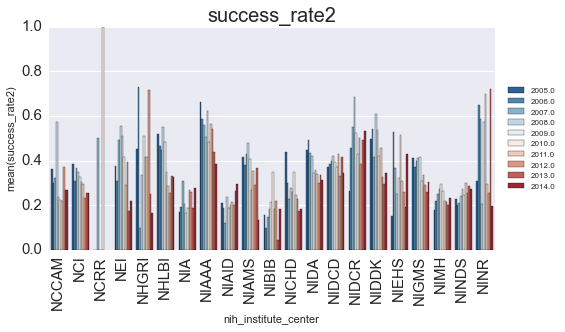

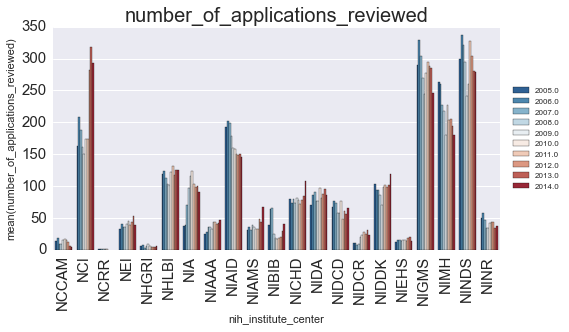

In [ ]:
variable_types = ['success_rate2', 'number_of_applications_reviewed']
n_yrs = len(subset.fiscal_year.unique())
pal = sns.color_palette('RdBu_r', n_colors=n_yrs)
for var in variable_types:
    f, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(x='nih_institute_center', y=var,
                data=subset, hue='fiscal_year', palette=pal)
    _ = plt.setp(ax.get_xticklabels(), rotation=90, fontsize=15)
    _ = plt.setp(ax.get_yticklabels(), fontsize=15)
    ax.legend(loc='right', bbox_to_anchor=(1.15, .5),
          ncol=1, fancybox=True, shadow=True, frameon=False, fontsize=8)
    ax.set_title(var, fontsize=20)

Is there anything that we can learn from this? Let's look at how the finding changed for each year: 

In [ ]:
yearly_change = subset.set_index(['nih_institute_center', 'fiscal_year'])['success_rate2'].\
    unstack('nih_institute_center')

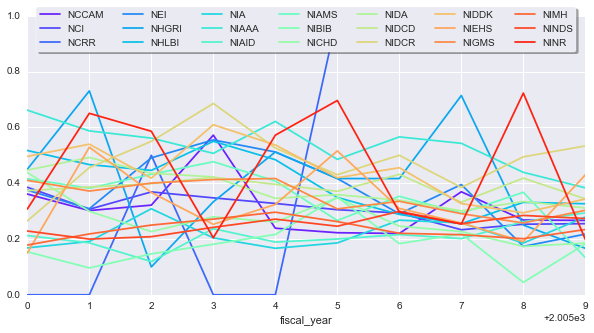

In [ ]:
sns.set_palette(sns.color_palette('rainbow', yearly_change.shape[1]))
ax = yearly_change.plot(figsize=(10, 5))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=7, fancybox=True, shadow=True, frameon=True)

To make things more comparable, we can normalize each timeseries by its first value, this will give everything the same starting point. We'll also smooth the curves a little bit to get an idea for general trends. We'll apply an exponentially-weighted moving average so recent points factor more into the average


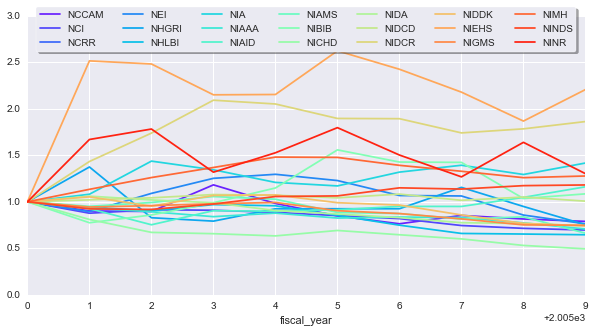

In [ ]:
# Normalize data and apply a bit of smoothing
yearly_change_norm = yearly_change / yearly_change.iloc[0]
ax = yearly_change_norm.apply(pd.stats.moments.ewma, span=5).\
    plot(figsize=(10, 5))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=7, fancybox=True, shadow=True, frameon=True)

It seems like some NIH groups have made out better than others. Maybe this simply because the number of total applications each received changed from one year to another. 

As a final analysis, we can look at how the yearly change in applications is correlated with a success rate.

Positive lines mean that more applications tend to have a higher success rate, negative lines mean more apps have a lower success rate. I'll also color each point by the fiscal year it came from - hotter colors mean more recent years.

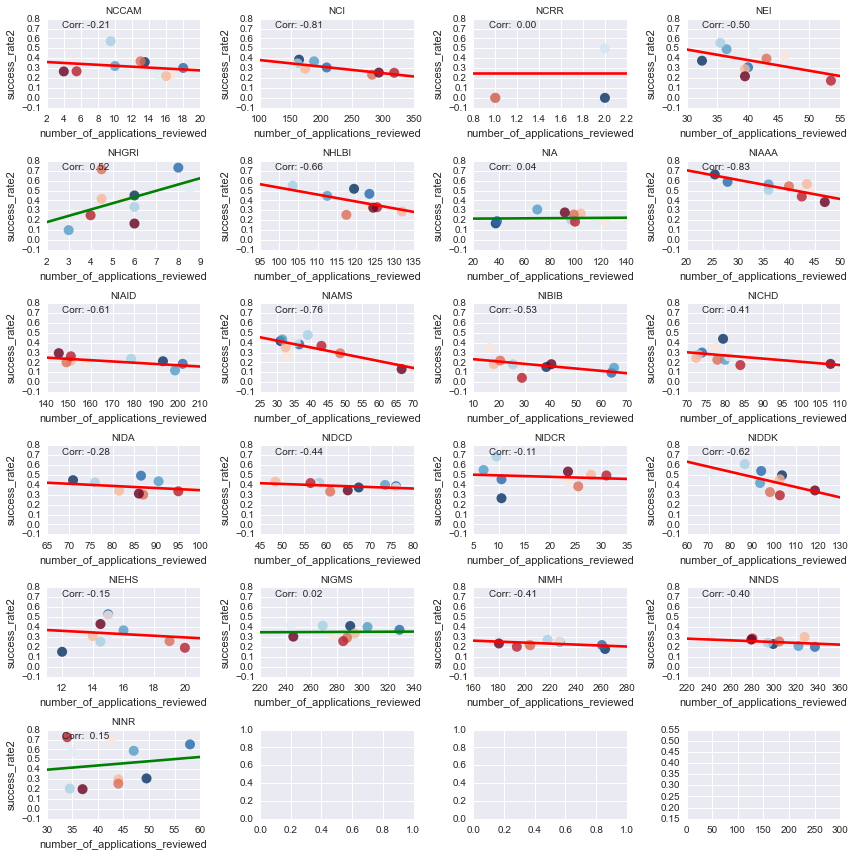

In [ ]:
grp_cent = subset.groupby('nih_institute_center')
n_cl = 4
n_rw = np.ceil(len(grp_cent) / float(n_cl)).astype(int)
f, axs = plt.subplots(n_rw, n_cl, figsize=(3*n_cl, 2*n_rw))
for (cent, vals), ax in zip(grp_cent, axs.ravel()):
    yr = vals['fiscal_year'] / 100
    corr = np.corrcoef(*vals[['number_of_applications_reviewed', 'success_rate2']].values.T)[1, 0]
    lc = str(np.where(corr > 0, 'g', 'r'))
    sns.regplot('number_of_applications_reviewed', 'success_rate2',
                data=vals, ax=ax, scatter_kws={'s': yr*5, 'c': yr, 'cmap': plt.cm.RdBu_r},
                line_kws={'c': lc}, ci=None)
    ax.set(ylim=[-.1, .8])
#     sns.corrplot(vals.set_index(['fiscal_year']), cbar=False, ax=ax)
    ax.set_title(cent, fontsize=10)
    ax.annotate('Corr: {0: .02f}'.format(corr), (.1, .9),
                xycoords='axes fraction', fontsize=10)
plt.tight_layout()
_ = plt.setp([ax.get_xticklabels() + ax.get_yticklabels()
              for ax in axs.ravel()], fontsize=10)
_ = plt.setp([ax.xaxis.label, ax.yaxis.label], fontsize=10)

So what did we learn from any of this? Well, it seems like the funding landscape at the NIH is changing, and some groups are making out better than others.

There are power players who've been around for a while, like the NINDS, who haven't seen a huge change in their granting behavior. Other groups, such as NIAAA, have seen their success rates decline steadily w/ increased applications. On the other hand, there are some centers that have actually shown both an increase in applications AND an increase in success rates (such as the NHGRI), which may reflect increased interest in those research endeavors from congress etc.

There's a lot more to be read into this data, so I encourage people to check it out for themselves, or suggest things to try out on top of what's already here. It's been fun learning a bit about the landscape of grants at the NIH.

# Appendix
## NIH acronym lookup

In [ ]:
data['nih_institute_center'].unique()
nih_centers = {u'NCCAM': 'National Center for Complementary and Alternative Medicine',
                 u'NINDS': 'National Institute on Neurological Disorders and Stroke',
                 u'NIDA': 'National Institute on Drug Abuse',
                 u'NIDCD': 'National Institute on Deafness and Other Communication Disorders',
                 u'NIDCR': 'National Institute of Dental and Craniofacial Research',
                 u'NIEHS': 'National Institute of Environmental Health Sciences',
                 u'NIMH':  'National Institute of Mental Health',
                 u'NIAAA': 'National Institute on Alcohol Abuse and Alcoholism',
                 u'NIA': 'National Institute on Aging',
                 u'NIAID': 'National Institute of Allergy and Infectious Diseases',
                 u'NIAMS': 'National Institute of Arthritis and Musculoskeletal and Skin Diseases',
                 u'NCI': 'National Cancer Institute',
                 u'NIDDK': 'National Institute of Diabetes and Digestive and Kidney Diseases',
                 u'NIBIB': 'National Institute of Biomedical Imaging and Bioengineering',
                 u'NEI': 'National Eye Institute',
                 u'NIGMS': 'National Institute of General Medical Sciences',
                 u'NICHD': 'National Institute of Child Health and Human Development',
                 u'NHGRI': 'National Human Genome Research Institute',
                 u'NHLBI': 'National Heart, Lung, and Bloog Institute',
                 u'NINR': 'National Institute of Nursing Research',
                 u'NCRR': 'National Center for Research Resources',
                 u'NLM': 'National Library of Medicine'}
for ac, cent in nih_centers.iteritems():
    print('{0}:\t{1}'.format(ac, cent))